In [46]:
from qiskit import QuantumCircuit
from qiskit.circuit import QuantumRegister,ClassicalRegister
from qiskit_machine_learning.neural_networks import EstimatorQNN,SamplerQNN
from IPython.display import clear_output
import matplotlib.pyplot as plt
import qiskit.quantum_info as qi
from qiskit.circuit import ParameterVector
from qiskit_algorithms.utils import algorithm_globals
import time 
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import EfficientSU2,RealAmplitudes
import numpy as np

import pickle 
import time
from qiskit.circuit.library import iSwapGate
from math import comb

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer import AerSimulator
from qiskit.circuit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator
sqrt_iSWAP = iSwapGate().power(1/2)

from matplotlib import colormaps
list(colormaps)
cmap = 'gist_heat'

from Z2_2flavourClass import Z2_2flavour

In [47]:
# matter_defect = [7,12]
# nLinks = 7

matter_defect = np.array([9,7])
nLinks = 5
charge_loc_initial = (nLinks*3+2) - matter_defect -1
print(charge_loc_initial)
nShots = 100000 


dtFactor = 0.2
Trotter_time = np.arange(dtFactor,10*dtFactor,dtFactor)
nTrotter_total = Trotter_time.shape[0]
dt_min = 0.4
nTrotter_list = np.ceil(Trotter_time/dt_min)
dt_list = Trotter_time/nTrotter_list

initial = '11011010001011011' 
initial = np.array([int(numeric_string) for numeric_string in initial])  
print(initial)

[7 9]
[1 1 0 1 1 0 1 0 0 0 1 0 1 1 0 1 1]


In [28]:
string_name = 'stringList_torino_17evo_2025-02-28_nCharges_2.pkl.pkl'

In [29]:
with open(string_name, 'rb') as file:
    string_list_evo = pickle.load(file)

In [5]:
from Z2_2flavourClass import getChargeLoc_fromString

In [6]:
# p1, p2 = getChargeLoc_fromString(string_list_evo,nLinks)

nTrotter_1_dtRescale_0.2
nTrotter_1_dtRescale_0.4
nTrotter_2_dtRescale_0.30000000000000004
nTrotter_2_dtRescale_0.4
nTrotter_3_dtRescale_0.3333333333333333
nTrotter_3_dtRescale_0.39999999999999997
nTrotter_4_dtRescale_0.35000000000000003
nTrotter_4_dtRescale_0.4
nTrotter_5_dtRescale_0.36


In [93]:
bkg2 = 0.049366837449414724
bkg4 = 0.10409732260044273
d_bkg = (bkg4 - bkg2)/2

bkg1 = bkg2 - d_bkg
bkg3 = bkg2 + d_bkg
bkg5 = bkg4 + d_bkg
bkg = np.array([bkg1,bkg1,bkg2,bkg2,bkg3,bkg3,bkg4,bkg4,bkg5]) 

In [94]:
def removeBKG(p,bkg):
    output = []
    for i in range(len(p)):
        out  = p[i] - bkg[i]
        out[out<0] = 0
        output.append(out)
    
        
    return np.array(output)

In [95]:
p1_sig = removeBKG(p1,bkg)
p2_sig = removeBKG(p2,bkg)

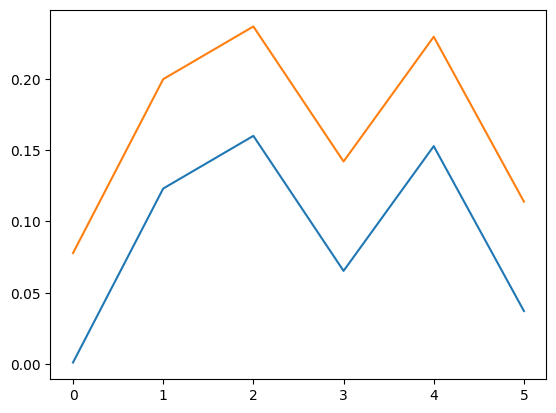

In [96]:
plt.plot(p1_sig[-4])
plt.plot(p1[-4])

In [97]:
weight1 = p1_sig/p1
weight2 = p2_sig/p2

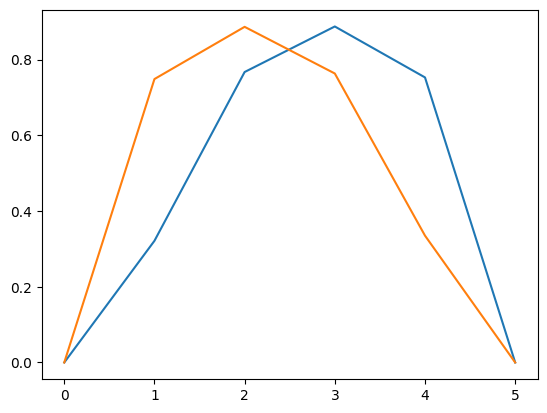

In [98]:
ind = 2
plt.plot(weight1[ind]);
plt.plot(weight2[ind]);



In [99]:
def getChargeLocs(tmpKey):
    tmpKey = 1-tmpKey  
        
    tmp_charge1 = []
    tmp_charge2 = []
    for i in range(len(tmpKey)):
        if (i+1)%3 == 1:
            tmp_charge1.append(tmpKey[i])
        elif (i+1)%3 == 2:
            tmp_charge2.append(tmpKey[i])
                
    tmp_charge1 = np.array(tmp_charge1)
    tmp_charge2 = np.array(tmp_charge2)
    return tmp_charge1, tmp_charge2
    
def getEVs_loc(loc1,loc2,initial = initial,matter_defect = matter_defect):
    evs = initial.copy()
    charge_index = [loc1,loc2]
    
    evs[matter_defect[0]]=1
    evs[matter_defect[1]]=1
    
    evs[loc1]=0
    evs[loc2]=0


    
    if charge_index[0] < matter_defect[0]:
        for j in range(charge_index[0],matter_defect[0],1):
            if (j+1)%3==0:
                evs[j] = (evs[j]+1)%2 #flippng!

    elif charge_index[0] > matter_defect[0]:
        for j in range(matter_defect[0],charge_index[0],1):
            if (j+1)%3==0:
                evs[j] = (evs[j]+1)%2 #flippng!


    #second charge                  
    if charge_index[1] < matter_defect[1]:
        for j in range(charge_index[1],matter_defect[1],1):
            if (j+1)%3==0:
                evs[j] = (evs[j]+1)%2 #flippng!
    elif charge_index[1] > matter_defect[1]:
        for j in range(matter_defect[1],charge_index[1],1):
            if (j+1)%3==0:
                evs[j] = (evs[j]+1)%2 #flippng!
        
        
    evs = 1 - 2*evs
    for i in range(evs.shape[0]): #introduce a negative sign for all the matter site
        if (i+1)%3 != 0:
            evs[i] = -evs[i]
            
    return (evs + 1)/2
    
    
    
def getEVs_weight(strings,nLinks,weight1,weight2): #input is a job result
    p_list = []
    
    evs = np.zeros(3*nLinks+2)
    weights_all = 0
    
    for i,key in enumerate(strings.keys()):
        
        tmpKey = np.array([int(numeric_string) for numeric_string in key])  
        tmp_charge1, tmp_charge2 =  getChargeLocs(tmpKey)
        
        if tmp_charge1.sum() == 1 and tmp_charge2.sum() == 1:
            weight = strings[key]
            loc1 = np.where(tmp_charge1 == 1)[0][0]
            loc2 = np.where(tmp_charge2 == 1)[0][0]
         
            tmp_evs = getEVs_loc(loc1*3,loc2*3+1) # overall position in the evs
            tmp_weight = weight*weight1[loc1]*weight1[loc2]
            
            evs += tmp_evs * tmp_weight
            weights_all += tmp_weight
    return evs, weights_all

In [100]:
evs,w = getEVs_weight(string_list_evo['nTrotter_1_dtRescale_0.2'][0],nLinks,weight1[0],weight2[0])

In [101]:
evs_all_reweighted = []

for i,key in enumerate(string_list_evo.keys()):
    
    tmp_list = string_list_evo[key]
    tmp_evs = np.zeros(nLinks*3+2)
    tmp_w = 0
    print(i,key, len(tmp_list))
    
    for l in tmp_list:
        evs,w = getEVs_weight(string_list_evo[key][0],nLinks,weight1[i],weight2[i])
        tmp_evs += evs
        tmp_w += w
        
    evs_all_reweighted.append(tmp_evs / tmp_w)
    
evs_all_reweighted = np.array(evs_all_reweighted)

0 nTrotter_1_dtRescale_0.2 10
1 nTrotter_1_dtRescale_0.4 10
2 nTrotter_2_dtRescale_0.30000000000000004 20
3 nTrotter_2_dtRescale_0.4 20
4 nTrotter_3_dtRescale_0.3333333333333333 30
5 nTrotter_3_dtRescale_0.39999999999999997 30
6 nTrotter_4_dtRescale_0.35000000000000003 40
7 nTrotter_4_dtRescale_0.4 40
8 nTrotter_5_dtRescale_0.36 49


<Figure size 640x480 with 0 Axes>

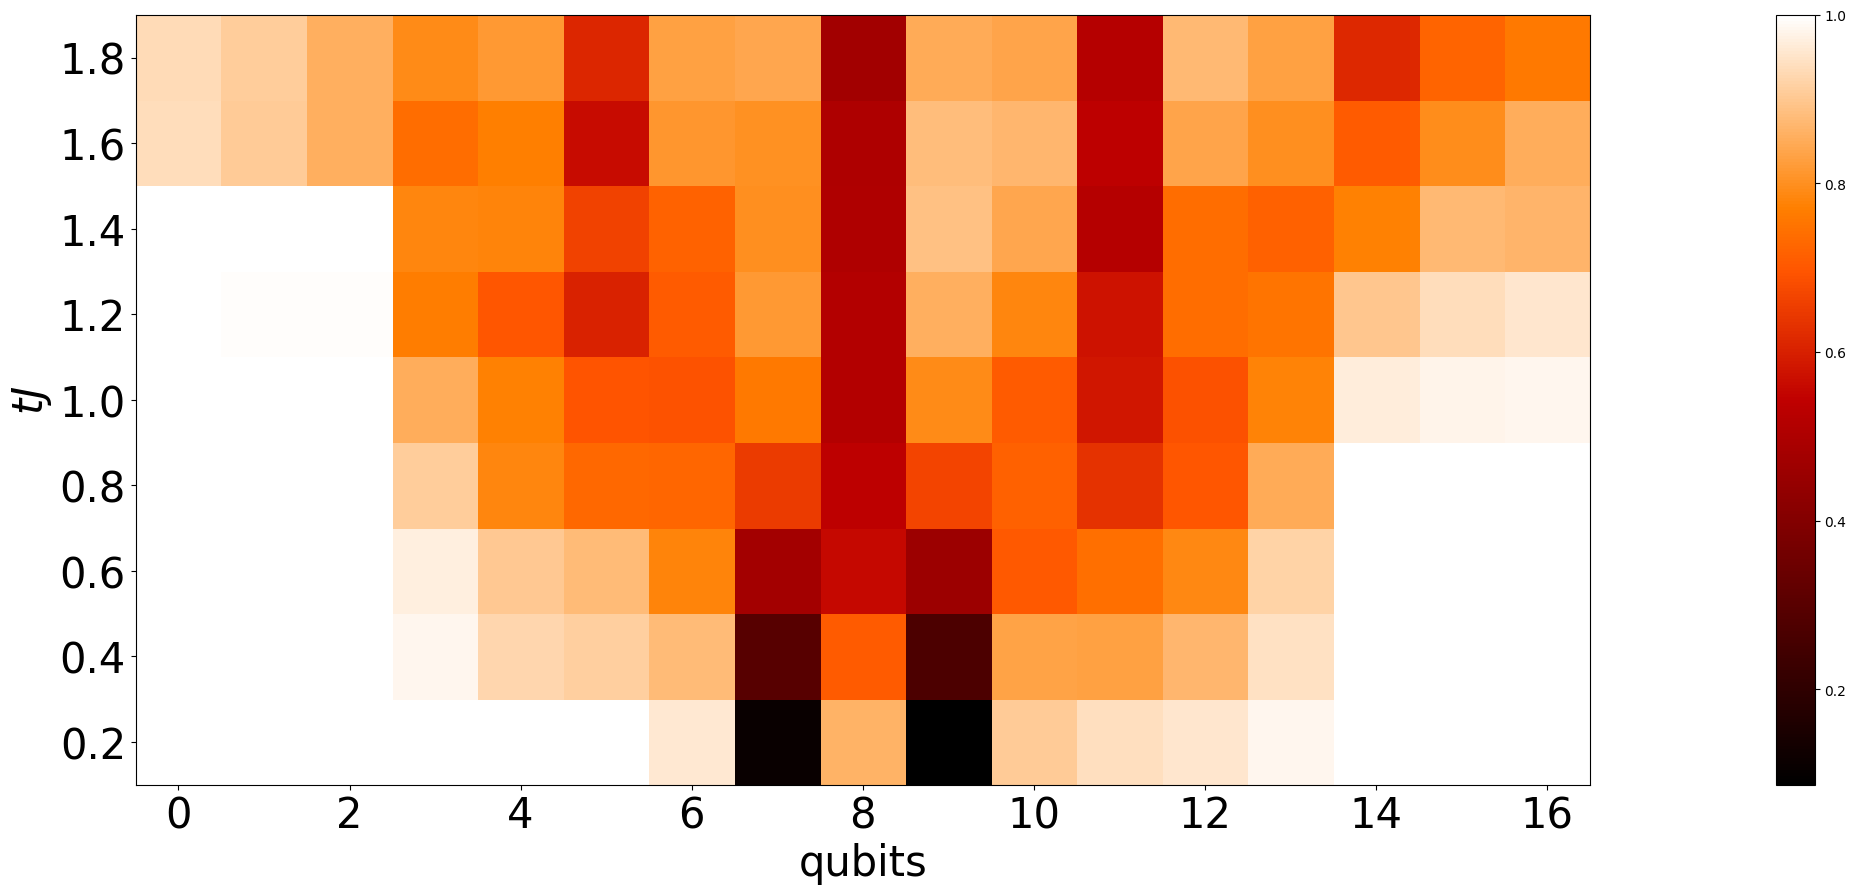

In [102]:

LabelSize=30
plt.figure(1)
plt.figure(figsize=(30,10))
plt.imshow(evs_all_reweighted, interpolation='none',origin='lower',cmap = cmap)

y=Trotter_time *1
plt.yticks(range(len(y)), np.round(y,2))
plt.xlabel('qubits',fontsize=LabelSize)
plt.ylabel(r'$tJ$',fontsize=LabelSize)
plt.tick_params(axis='both', which='major', labelsize=LabelSize)
plt.colorbar(fraction=0.03, pad=0.08)
#plt.savefig(name+".png", dpi=100,bbox_inches='tight')
